# Mercari Data Capstone Project - Data Wrangling

The objective for this portion of the project is to load in the raw data set that we will be analyzing, understand each of the columns and what they represent, and to then clean up any missing or invalid values. Fortunately because we are only loading in data from a single csv file, we won't have to go through the trouble of joining together several disjointed tables together.

# Background

Mercari is an online shopping website where sellers are able to freely set their own prices on products. Unlike for example Amazon, sellers on Mercari are all individuals rather than companies, who already know what prices to place on their products. Therefore, determining prices is more tricky for these individual sellers on Mercari. Not only do they need to take into account the branding and the quality of their item, but also its current condition. Our goal is to provide Mercari with more insight as to how to automatically suggest appropriate prices to their sellers.

In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
#Reading in Data
path = "/Users/jasonzhou/Documents/GuidedCapstone2"
os.chdir(path)
mercari_data = pd.read_csv("TrainMercari.csv")
mercari_data = mercari_data.rename(index=str, columns = {"name":"Name", "item_condition_id":"Condition",
                                                        "category_name":"Category", "brand_name":"Brand",
                                                        "price":"Price", "shipping":"Shipping",
                                                        "item_description":"Item Description"})
mercari_data = mercari_data.drop(columns=['train_id'])

In [3]:
# Determining number of rows and columns
mercari_data.shape

(1048575, 7)

In [4]:
#Fetching a preview of the dataset to make sure it was imported correctly without complications
mercari_data.head()

,Name,Condition,Category,Brand,Price,Shipping,Item Description
0,"- ""Litty"" Available in Multi Plus Sizes",1,Women/Tops & Blouses/Blouse,NaN,21,0,"- Blue , Distressed Top . Comes in 1x , 2x & 3..."
1,--- 2 pcs great universal earphone,1,"Electronics/TV, Audio & Surveillance/Headphones",NaN,10,1,Brand new best quality headphones for iphone6s...
2,' BARE WITH ME ' DOSE OF COLORS,1,Beauty/Makeup/Lips,Sephora,14,1,Liquid matte lipstick Beautiful nude color Bra...
3,' BERRY ME ' DOSE OF COLORS,1,Beauty/Makeup/Lips,Sephora,14,0,Matte liquid lipstick Brand new in box Dries t...
4,' BLIMEY LIMEY ' LOOSE GLITTER,2,Beauty/Makeup/Makeup Sets,NaN,5,1,COSMETIC LOOSE GLITTER! SPARKLES And SHINES!! ...


# Data - Column Descriptions

So it appears that our data is simply a large row of item listings on Mercari, and its columns are pretty straightforward. Here is a description for each:

Name: name of the listing

Condition: the condition that the item is in. Condition is rated on a scale from 1 to 5, with 1 being the highest rating and 5 being the lowest

Category: the category that the item falls under. Examples include electronics, fashion, household, with even more specific subcategories and so on

Brand: the brand of the item, if applicable. Examples include Nike, Sephora, lululemon, Apple, etc.

Price: the amount of payment that the buyer pays to the seller

Shipping: whether or not the seller is paying for shipping. The value of "shipping" is "0" if the seller is not paying for shipping fees, and is "1" if they are

Item Description: a short summary of the item, if applicable

As our first step into our table, lets just call a quick .describe() function on it

In [5]:
#Quick Summary of the Data

pd.set_option('display.float_format', lambda x: '%.5f' % x)
mercari_data.describe()

,Condition,Price,Shipping
count,1048575.00000,1048575.00000,1048575.00000
mean,1.90743,26.73614,0.44741
std,0.90308,38.58335,0.49723
min,1.00000,0.00000,0.00000
25%,1.00000,10.00000,0.00000
50%,2.00000,17.00000,0.00000
75%,3.00000,29.00000,1.00000
max,5.00000,2009.00000,1.00000


# Investigating Each Column

Very quickly this tells us which of our features are numeric. 

The values of Condition all appear to be valid, with the values all being between 1 and 5. According to the mean, it appears that most items are on average skew more towards being in better condition.

Lets get a visual representation of this column:

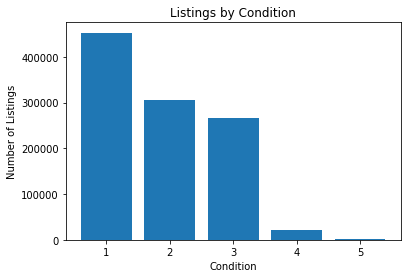

In [6]:
conditions = ['1', '2', '3', '4', '5']

_ = plt.title("Listings by Condition")
_ = plt.xlabel('Condition')
_ = plt.ylabel('Number of Listings')
_ =plt.bar(conditions, mercari_data['Condition'].value_counts())

Now on to Price. Lets start out with a visual representation:

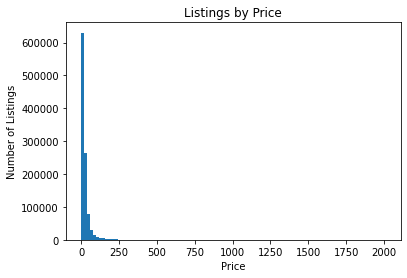

In [7]:
_ = plt.hist(mercari_data['Price'], bins=100)
_ = plt.title("Listings by Price")
_ = plt.xlabel('Price')
_ = plt.ylabel('Number of Listings')

The massive outliers in 'Price' make it rather difficult to see the majority of the histogram clearly. The data skews very heavily to the right, so we will take a log of the column in order to standardize the scale a bit more. We'd be running into issues if we had any values of Price that were 0, so we'll look into that later.

Now to talk about "Shipping". Let's get a visual representation first:

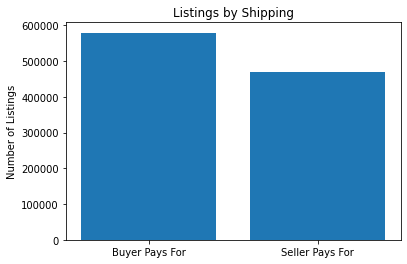

In [13]:
shippings = ['Buyer Pays For', 'Seller Pays For']

_ = plt.title("Listings by Shipping")
_ = plt.ylabel('Number of Listings')
_ =plt.bar(shippings, mercari_data['Shipping'].value_counts())

On average, it is more common for the seller to not pay for shipping fees, but not by much. And again, all values of Shipping appear to be valid, with no values that aren't 0 or 1.

Now, to look at the Brand column.

In [11]:
mercari_data['Brand'].value_counts()

Nike                 38161
PINK                 38123
Victoria's Secret    34159
LuLaRoe              21900
Apple                12222
                     ...  
Testament                1
Silkland                 1
Donna Bella              1
Bio Spot                 1
Lullaby Earth            1
Name: Brand, Length: 4383, dtype: int64

So it appears that we have 4,383 unique brands, with some popular ones like Nike and PINK having a ton of listings, with many presumably less well known brands having very few listings. I'm interested in seeing how many brands have 5 or less listings:

In [14]:
# Find how many brands have a valuecount of less than 5

smallbrands = mercari_data[mercari_data['Brand'].isin(mercari_data['Brand'].value_counts()[mercari_data['Brand'].value_counts() <= 5].index)].Brand.unique()
len(smallbrands)

2475

So roughly half of the unique brands in the entire dataset are at 5 listings or less. Lets now see a more comprehensive breakdown of listings per brand.

In [13]:
# Same code as last cell but with an array of inputs

thresholds = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
thresholdlabels = ['1', '5', '10', '50', '100', '500', '1000', '5000', '10000']
brandcounts = [0] * 9
index = 0

for threshold in thresholds:
    brandcounts[index] = len(mercari_data[mercari_data['Brand'].isin(mercari_data['Brand'].value_counts()[mercari_data['Brand'].value_counts() >= thresholds[index]].index)].Brand.unique())
    index += 1


[4383, 2082, 1524, 689, 463, 180, 111, 20, 8]


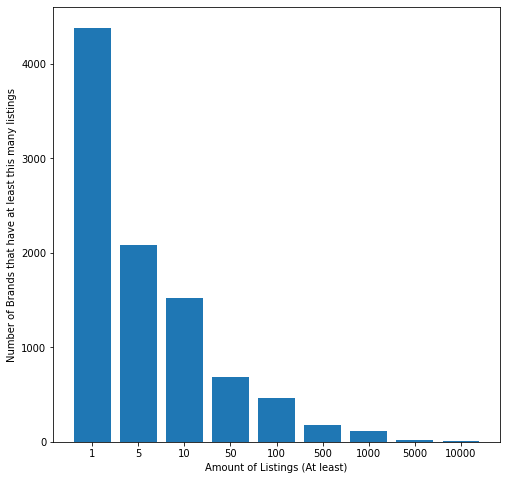

In [15]:
plt.figure(figsize=(8, 8))
plt.xlabel('Amount of Listings (At least)')
plt.ylabel('Number of Brands that have at least this many listings')
plt.bar(thresholdlabels, brandcounts)

print(brandcounts)

This graph gives some insight as to what the brand distribution on Mercari roughly is. The site isn't particularly top heavy, as 1500 brands have at least 10 listings and 700 brands have at least 50.

Now lets have a look at category.

In [16]:
#Investigating how many total categories there are
mercari_data['Category'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    42262
Women/Tops & Blouses/T-Shirts                     32736
Beauty/Makeup/Face                                24267
Beauty/Makeup/Lips                                21136
Electronics/Video Games & Consoles/Games          18737
                                                  ...  
Sports & Outdoors/Team Sports/Badminton               1
Handmade/Bags and Purses/Diaper Bag                   1
Handmade/Housewares/Bathroom                          1
Handmade/Weddings/Just Married                        1
Handmade/Dolls and Miniatures/Plush                   1
Name: Category, Length: 1258, dtype: int64

There appear to be 1258 categories total, with a large variety of items per category. Similar to brand, I want to see a breakdown of the distribution of listings by category.

In [17]:
# Same code as from our 'Brand' work

categorycounts = [0] * 9
index = 0

for threshold in thresholds:
    categorycounts[index] = len(mercari_data[mercari_data['Category'].isin(mercari_data['Category'].value_counts()[mercari_data['Category'].value_counts() >= thresholds[index]].index)].Category.unique())
    index += 1


[1258, 1031, 915, 654, 544, 297, 188, 55, 24]


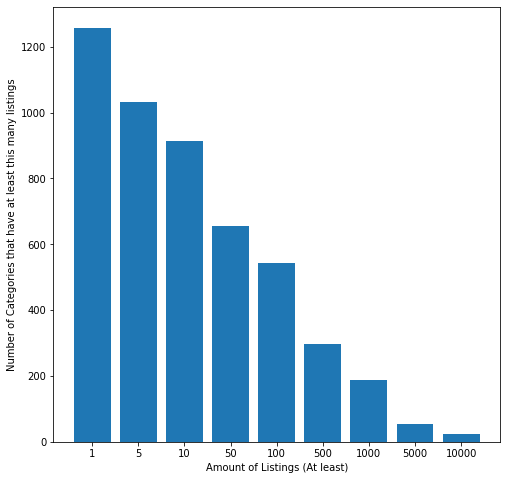

In [18]:
plt.figure(figsize=(8, 8))
plt.xlabel('Amount of Listings (At least)')
plt.ylabel('Number of Categories that have at least this many listings')
plt.bar(thresholdlabels, categorycounts)

print(categorycounts)

Interestingly enough the shape of this graph looks a lot more linear compared to the graph of "Brand", which looked more exponential. This leads us to believe that listings are distributed among categories even more evenly than brands.

Now to look at the Name column.

In [19]:
mercari_data['Name'].value_counts()

Bundle                                      1572
Reserved                                     325
Dress                                        312
BUNDLE                                       303
Converse                                     303
                                            ... 
BRAND NEW Black Pointed Flats                  1
Agnes and Dora Small Mint Hi Lo Tunic          1
Hollister Jeans - Venice Boot -free ship       1
Lot of Men's Large cloth belts                 1
Golden Girls yellow men shirt L                1
Name: Name, Length: 886108, dtype: int64

There are 886,108 unique values of Name, which suggests that this field isn't very useful as a categorical value. Furthermore, from just the first 5 Names of the list, it appears that some of the Name values are redundant with information available in other columns. For example lets look at all the listings named "Converse". Converse is a brand, and therefore we wouldn't have needed the Name field to properly identify it as such. Same goes for "Dress", this information could have already been determined from the listing's Category field. To investigate our suspicions, lets get some sample rows for listings with Name values of "Converse" and "Dress":

In [20]:
mercari_data[['Name', 'Brand', 'Category']][mercari_data['Name']=='Converse'].head(15)

,Name,Brand,Category
262459,Converse,Converse,NaN
262460,Converse,Converse Shoes,NaN
262461,Converse,NaN,Kids/Boys (4+)/Shoes
262462,Converse,NaN,Kids/Boys (4+)/Shoes
262463,Converse,NaN,Kids/Boys (4+)/Shoes
262464,Converse,Nike,Kids/Boys (4+)/Shoes
262465,Converse,NaN,Kids/Boys (4+)/Shoes
262466,Converse,NaN,Kids/Boys (4+)/Shoes
262467,Converse,NaN,Kids/Boys 0-24 Mos/Shoes
262468,Converse,NaN,Kids/Boys 0-24 Mos/Shoes


In [21]:
mercari_data[['Name', 'Brand', 'Category']][mercari_data['Name']=='Dress'].head(15)

,Name,Brand,Category
298220,Dress,FOREVER 21,NaN
298221,Dress,NaN,Kids/Girls (4+)/Dresses
298222,Dress,NaN,Kids/Girls (4+)/Dresses
298223,Dress,Old Navy,Kids/Girls (4+)/Dresses
298224,Dress,NaN,Kids/Girls (4+)/Dresses
298225,Dress,NaN,Kids/Girls (4+)/Dresses
298226,Dress,NaN,Kids/Girls (4+)/Dresses
298227,Dress,NaN,Kids/Girls (4+)/Dresses
298228,Dress,NaN,Kids/Girls (4+)/Dresses
298229,Dress,NaN,Kids/Girls (4+)/Dresses


For our listings named "Dress", the vast majority of them were properly categorized with the relevant information we needed. However our "Converse" listings had a ton of missing Brand values, which raises some concern. If we were to drop the Name column, we would've lost the information that these listings were meant to be under the Converse brand, permanently. We will keep this in mind when we do our data cleaning later. Lets get a more comprehensive picture of how many listings are simply named by their brand, category, or both.

In [22]:
mercari_data['Name'].value_counts().head(30)

Bundle                  1572
Reserved                 325
Dress                    312
BUNDLE                   303
Converse                 303
Coach purse              281
Lularoe TC leggings      274
Nike                     250
Romper                   248
Vans                     243
American Eagle Jeans     211
Miss Me Jeans            207
Lularoe OS leggings      201
Shorts                   188
Coach Purse              186
ON HOLD                  185
Coach wallet             183
Lularoe Irma             180
Michael Kors Purse       177
Bundle!                  171
Miss me jeans            166
Nike shoes               163
Michael Kors Wallet      160
Lularoe TC Leggings      159
American eagle jeans     155
Michael Kors             152
Nike shorts              151
Jeans                    146
Rae Dunn                 145
Sandals                  144
Name: Name, dtype: int64

Most of the items in this list are not actual names of the listing, but just a rehashing of the item's brand, category or a combination of the two. We can use items such as these to potentially restore some missing values, namely in Brand. 

We do have some exceptions such as "Bundle" and its variations, "Reserved", and "ON HOLD". For these listings, it is true that the Name field provides information that can't be determined from Brand and Category. However these items combined make up about 3000 listings, which is less than 0.3% of the entire dataset. It would not be a substantial loss to the accuracy of our data analysis if we were to drop this information.

Now lets move on to Item Description.

In [23]:
mercari_data['Item Description'].value_counts()

No description yet                                                                        58341
New                                                                                        2898
Brand new                                                                                  2195
Good condition                                                                              877
Great condition                                                                             830
                                                                                          ...  
Super cute, flattering. No insert for pads, but is not see through due to the pattern.        1
Never used Never Fall Pouch from LV Authentic .                                               1
Wallet in use condition please see pics for flaws                                             1
Socks for baby newborn and up                                                                 1
Black small wallet/clutch barley used bo

Very similarly to Name, there are 913,717 unique values in Item Description, which doesn't make it very useful as a categorical variable. And as we can see, the most common item descriptions appear to contain redundant information. Lets look at more of the most common item descriptions just to make sure:

In [24]:
mercari_data['Item Description'].value_counts().head(30)

No description yet      58341
New                      2898
Brand new                2195
Good condition            877
Great condition           830
Like new                  697
Never worn                601
NWT                       568
New with tags             454
Excellent condition       432
Never used                424
Worn once                 420
Brand new with tags       335
Size small                326
Brand New                 316
Brand new!                314
New in box                312
BNWT                      308
Brand new.                283
Bundle                    280
Reserved                  262
NWOT                      254
Free shipping             250
Size medium               243
Brand new never used      224
In good condition         221
Nwt                       218
In great condition        189
Brand new in box          184
Size large                180
Name: Item Description, dtype: int64

As suspected, most of these item descriptions are just restating the item's condition, which can already be determined from the Condition field. The few exceptions do not justify keeping this column. 

# Data Cleaning

Lets first check to see how many missing values each column has:

In [18]:
#Now to find out exactly how many values are missing in each column
missing = pd.concat([mercari_data.isnull().sum(), 100 * mercari_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
Brand,447335,42.66123
Category,4503,0.42944
Item Description,2,0.00019
Name,0,0.00000
Condition,0,0.00000
Price,0,0.00000
Shipping,0,0.00000


Seems like there are an abundance of missing values in the Brand column, just a few in Category,
and just a handful in Item Description. 

It makes sense for there to be a large amount of listings without a relevant Brand value. Some items simply don't have brands, and others aren't the type of item where its brand is relevant. For example, people typically don't care about the brand when it comes to items like towels, slippers, or appliances. We're just going to drop any rows without Brand or Category values because these categorical features will be our main focus of data analysis. 

In [19]:
# Remove rows with missing Brand, Category, and item description values
mercari_data.dropna(inplace=True)

# Lets see how many rows we're left with now, compared to our initial 1 million
mercari_data.shape

(599214, 7)

In [20]:
# Dropping Name and Item Description
mercari_data.drop(['Name', 'Item Description'], axis=1, inplace=True)

# Check to see if columns were fully dropped, should only have 5 columns now
mercari_data.shape

(599214, 5)

Here we have to consider whether or not it's worth keeping rows with brands and categories that do not occur frequently in the data. Not only would keeping all the data make our data set massive after one hot encoding, but it's also not necessarily relevant data to have in the first place. If Brand X is only represented by one single row in the entire dataset, then we can't make any fair predictions based off of one data point of Brand X anyways. To account for the constraints of computational power, I've decided to drop any rows where the brand and/or category appear in less than 50 instances in the data. Based on the graphs constructed earlier, about 3000 brands and 300 categories will no longer occur in the data.

In [21]:
brandsCut = mercari_data[mercari_data['Brand'].isin(mercari_data['Brand'].value_counts()[mercari_data['Brand'].value_counts() <= 50].index)].Brand.unique()
mercari_data = mercari_data[~mercari_data['Brand'].isin(brandsCut)]

In [22]:
categoriesCut = mercari_data[mercari_data['Category'].isin(mercari_data['Category'].value_counts()[mercari_data['Category'].value_counts() <= 50].index)].Category.unique()
mercari_data = mercari_data[~mercari_data['Category'].isin(categoriesCut)]

In [11]:
mercari_data.shape

(567573, 5)

After doing some browsing around on the Mercari website, it doesn't seem possible to post an item for sale for $0, or giving it away for free. Let's see if we have any price values equal to 0.

In [23]:
mercari_data[mercari_data['Price']==0]

,Condition,Category,Brand,Price,Shipping
8238,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,Nars,0,1
19100,1,Women/Jewelry/Earrings,Stamped,0,1
21254,1,Kids/Boys 0-24 Mos/Tops & T-Shirts,Carter's,0,0
24396,2,Kids/Boys 2T-5T/Tops & T-Shirts,Ralph Lauren,0,1
28609,1,Beauty/Skin Care/Face,Sephora,0,0
...,...,...,...,...,...
1036787,2,Women/Dresses/Other,LuLaRoe,0,1
1036878,2,Women/Tops & Blouses/Blouse,Maurices,0,0
1040293,1,Men/Shoes/Fashion Sneakers,Yeezy,0,0
1043448,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,Younique,0,1


We do in fact, perhaps this data was entered incorrectly, but we should now just drop any row that has a price of 0.

In [24]:
mercari_data.drop(mercari_data[mercari_data['Price'] == 0].index, inplace = True)

Earlier we mentioned taking the log of our Price column to help with the distribution of it. Let's get a preview of what the data would look like if we did that.

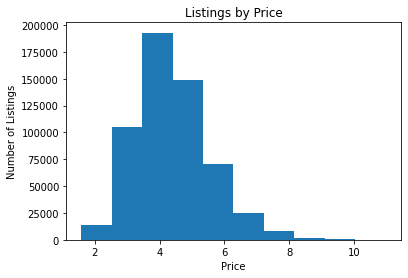

In [33]:
_ = plt.hist(mercari_data['Price'])
_ = plt.title("Listings by Price")
_ = plt.xlabel('Price')
_ = plt.ylabel('Number of Listings')

Much better, we'll go ahead and do it.

In [26]:
mercari_data['Price'] = np.log2(mercari_data['Price'])

In [27]:
# Verify that 'Price' was properly log'd

mercari_data['Price'].mean()

4.414677071779257

# Further Adjustments

The rating system on which Condition is based on may present an inconvenience. "1" represents top condition whereas "5" represents poor condition. However, numerically speaking this scale would imply the opposite. I think it would make the data analysis more straightforward if we were to swap the scale, and have "5" represent best condition, and the opposite for "1".

In [28]:
# Before
mercari_data['Condition'].value_counts()

1    204733
3    189271
2    157306
4     14748
5      1194
Name: Condition, dtype: int64

In [29]:
# Swapping the values in 'Condition'

# First we swap 1's with 5's
mercari_data['Condition'] = mercari_data['Condition'].replace(1, 0).replace(5, 1).replace(0, 5)

# Now 2's with 4's
mercari_data['Condition'] = mercari_data['Condition'].replace(2, 0).replace(4, 2).replace(0, 4)

# Verify that swapping was done successfully
print(mercari_data['Condition'].value_counts())

5    204733
3    189271
4    157306
2     14748
1      1194
Name: Condition, dtype: int64


Now, ought we do the same for "Shipping", or is it acceptable the way it is? Just as a recap, the value of '0' means that shipping fees will not be paid for by the seller and the buyer will need to pay it. '1' means that the seller will cover shipping fees. I don't think it makes more sense either way, as 'Shipping' isn't really a quantifiable metric, the '0' and '1' are purely categorical. It doesn't mean anything to say that numerically, a listing has a greater "Shipping" value than another.

We're all done here, now all we need to do is write out our cleaned and adjusted data set:

In [30]:
mercari_data.to_csv('MercariDataCleaned.csv')